In [41]:
%load_ext autoreload
%autoreload 2

In [72]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *
print(torch.cuda.is_available())

False


### Bivariate Normal Data Generation

In [47]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [4, 3],
    1: [3, 5],
    2: [3, 1],
    3: [1.5, 5]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

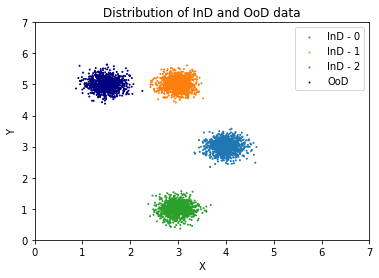

In [48]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

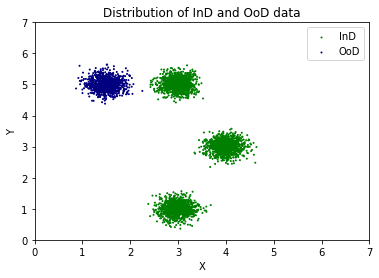

In [49]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [ ]:
from tqdm import tqdm
from simulation import classifier_training, DSIM_SINGLE, GSIM_SINGLE
# D = DSIM()
D = DSIM_SINGLE()
# Configuration
max_epoch = 256
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

#### Plot

### WOOD Training

In [ ]:
from simulation import *
D_WOOD = DSIM(64)
# D_WOOD = DSIM_SINGLE()
# OOD data preparation
n_ood = 4
ood_bsz = 4
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-3
beta = 1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

In [64]:
from simulation import calculate_accuracy
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.95)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.99)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.99)
# calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.999)
calculate_accuracy(D=D_WOOD, ind=IND_X, ood=OOD_X, tnr=0.999)

0.95: 1.0
0.99: 1.0
0.999: 1.0


0.00012420853250660609

### OOD GAN Training

In [70]:
from simulation import *
from wasserstein import *
D_GAN = DSIM(64)
G_GAN = GSIM(64)
# D_GAN = DSIM_SINGLE(64)
# G_GAN = GSIM_SINGLE(64)
# OOD data preparation
# n_ood = 8
ood_bsz = 4
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 256
lr = 1e-4
w_ce, w_wass, w_dist = 1, 1, 0.1
scaling = 0.1
d_step_ratio, g_step_ratio = 3, 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=bsz_tri)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=bsz_tri)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist, scaling,\
                    d_step_ratio, g_step_ratio, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([4, 2])


  0%|          | 0/256 [00:00<?, ?it/s]

Step: 0    | D:  1.1271 | CE:  1.3404 | W_OoD:  0.2401 | W_z:  0.2689 | G: -0.0269 | W_z:  0.2686 | dist: 2.9290
Step: 10   | D:  0.9176 | CE:  1.2018 | W_OoD:  0.3096 | W_z:  0.2540 | G: -0.0253 | W_z:  0.2528 | dist: 2.9817
Step: 20   | D:  0.8396 | CE:  1.1361 | W_OoD:  0.3193 | W_z:  0.2285 | G: -0.0228 | W_z:  0.2277 | dist: 3.0303
Step: 30   | D:  0.7477 | CE:  1.0609 | W_OoD:  0.3337 | W_z:  0.2053 | G: -0.0205 | W_z:  0.2046 | dist: 3.0615
Step: 40   | D:  0.5790 | CE:  0.9190 | W_OoD:  0.3584 | W_z:  0.1846 | G: -0.0184 | W_z:  0.1837 | dist: 3.0898


  0%|          | 1/256 [01:48<7:39:55, 108.22s/it]

Epoch  # 1 | Val accuracy: 0.9817
Step: 3    | D:  0.5009 | CE:  0.8721 | W_OoD:  0.3877 | W_z:  0.1649 | G: -0.0164 | W_z:  0.1639 | dist: 3.0948
Step: 13   | D:  0.4581 | CE:  0.8323 | W_OoD:  0.3878 | W_z:  0.1371 | G: -0.0136 | W_z:  0.1358 | dist: 3.0614
Step: 23   | D:  0.4104 | CE:  0.7873 | W_OoD:  0.3884 | W_z:  0.1147 | G: -0.0114 | W_z:  0.1139 | dist: 3.0123
Step: 33   | D:  0.4025 | CE:  0.7806 | W_OoD:  0.3879 | W_z:  0.0971 | G: -0.0097 | W_z:  0.0965 | dist: 2.9708
Step: 43   | D:  0.3639 | CE:  0.7428 | W_OoD:  0.3872 | W_z:  0.0826 | G: -0.0082 | W_z:  0.0822 | dist: 2.9255


  1%|          | 2/256 [03:38<7:43:01, 109.38s/it]

Step: 6    | D:  0.3367 | CE:  0.7179 | W_OoD:  0.3882 | W_z:  0.0701 | G: -0.0070 | W_z:  0.0696 | dist: 2.9011
Step: 16   | D:  0.3509 | CE:  0.7328 | W_OoD:  0.3879 | W_z:  0.0593 | G: -0.0059 | W_z:  0.0588 | dist: 2.8624
Step: 26   | D:  0.3011 | CE:  0.6837 | W_OoD:  0.3875 | W_z:  0.0497 | G: -0.0049 | W_z:  0.0494 | dist: 2.8327
Step: 36   | D:  0.2320 | CE:  0.6157 | W_OoD:  0.3879 | W_z:  0.0415 | G: -0.0041 | W_z:  0.0412 | dist: 2.8152


  1%|          | 3/256 [05:26<7:39:14, 108.91s/it]

Step: 46   | D:  0.2361 | CE:  0.6206 | W_OoD:  0.3879 | W_z:  0.0347 | G: -0.0034 | W_z:  0.0345 | dist: 2.8268
Step: 9    | D:  0.2332 | CE:  0.6173 | W_OoD:  0.3871 | W_z:  0.0295 | G: -0.0029 | W_z:  0.0293 | dist: 2.8136
Step: 19   | D:  0.2075 | CE:  0.5926 | W_OoD:  0.3876 | W_z:  0.0252 | G: -0.0025 | W_z:  0.0251 | dist: 2.7995
Step: 29   | D:  0.1704 | CE:  0.5559 | W_OoD:  0.3876 | W_z:  0.0217 | G: -0.0022 | W_z:  0.0217 | dist: 2.7746
Step: 39   | D:  0.1250 | CE:  0.5106 | W_OoD:  0.3875 | W_z:  0.0189 | G: -0.0019 | W_z:  0.0188 | dist: 2.7488


  2%|▏         | 4/256 [07:15<7:36:37, 108.72s/it]

Step: 2    | D:  0.1397 | CE:  0.5252 | W_OoD:  0.3872 | W_z:  0.0166 | G: -0.0017 | W_z:  0.0165 | dist: 2.7295
Step: 12   | D:  0.1173 | CE:  0.5023 | W_OoD:  0.3865 | W_z:  0.0145 | G: -0.0014 | W_z:  0.0144 | dist: 2.6841
Step: 22   | D:  0.0647 | CE:  0.4503 | W_OoD:  0.3868 | W_z:  0.0128 | G: -0.0013 | W_z:  0.0128 | dist: 2.6310
Step: 32   | D:  0.0972 | CE:  0.4822 | W_OoD:  0.3861 | W_z:  0.0116 | G: -0.0011 | W_z:  0.0115 | dist: 2.5782
Step: 42   | D:  0.0720 | CE:  0.4568 | W_OoD:  0.3859 | W_z:  0.0110 | G: -0.0011 | W_z:  0.0111 | dist: 2.4745


  2%|▏         | 5/256 [08:56<7:23:05, 105.92s/it]

Step: 5    | D:  0.0533 | CE:  0.4381 | W_OoD:  0.3858 | W_z:  0.0110 | G: -0.0011 | W_z:  0.0109 | dist: 2.3612
Step: 15   | D:  0.0546 | CE:  0.4396 | W_OoD:  0.3862 | W_z:  0.0123 | G: -0.0012 | W_z:  0.0118 | dist: 2.2186


  2%|▏         | 5/256 [09:52<8:15:50, 118.53s/it]


KeyboardInterrupt: 

### Plot

In [57]:
from simulation import plot_heatmap
n_ind, n_ood = 25, 25
ind_idx = np.random.choice(len(IND_X), n_ind, replace=False)
ood_idx = np.random.choice(len(OOD_X), n_ood, replace=False)

#### Plot Naive Classifier

torch.Size([10000, 3])
0.99: 0.0


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

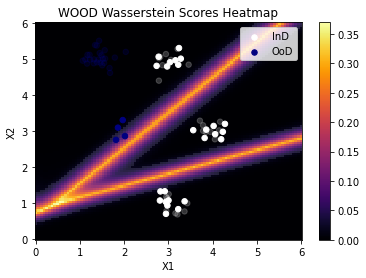

In [61]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D, "NAIVE", ind_idx, ood_idx, 100)

#### Plot WOOD

torch.Size([10000, 3])
0.99: 1.0


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

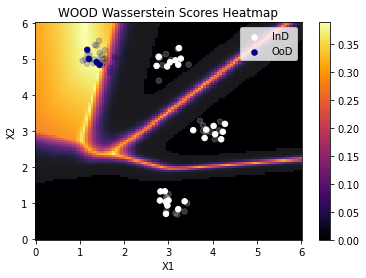

In [65]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_WOOD, "WOOD", ind_idx, ood_idx, m=100)

#### Plot GAN

In [ ]:
plot_heatmap(IND_X, IND_X_TEST, OOD_X, OOD_BATCH, D_GAN, "OOD-GAN", ind_idx, ood_idx, m=100)

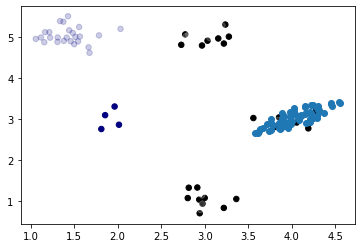

In [62]:
seed = torch.rand((bsz_tri, 2), device=DEVICE)
Gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0][ind_idx], IND_X[:,1][ind_idx], c='black', label ="InD", sizes=[30]*len(IND_X), alpha=1)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", sizes=[30]*len(OOD_X), alpha=1)
plt.scatter(IND_X_TEST[:,0][ind_idx], IND_X_TEST[:,1][ind_idx], c='white', sizes=[30]*len(IND_X), alpha=0.2)
plt.scatter(OOD_X[:,0][ood_idx], OOD_X[:,1][ood_idx], c='navy', sizes=[30]*len(OOD_X), alpha=0.2)
plt.scatter(Gz[:,0], Gz[:,1])

### Save

In [556]:
torch.save(D, "simulation_log/example/D.pt")
torch.save(D_WOOD, "simulation_log/example/D_WOOD.pt")
torch.save(D_GAN, "simulation_log/example/D_GAN.pt")
torch.save(G_GAN, "simulation_log/example/G_GAN.pt")
torch.save(OOD_BATCH,"simulation_log/example/OOD_BATCH.pt")
torch.save(OOD_X,"simulation_log/example/OOD_X.pt")
torch.save(OOD_X_TEST,"simulation_log/example/OOD_X_TEST.pt")
torch.save(IND_X,"simulation_log/example/IND_X.pt")
torch.save(IND_X_TEST,"simulation_log/example/IND_X_TEST.pt")
torch.save(IND_Y,"simulation_log/example/IND_Y.pt")
torch.save(IND_Y_TEST,"simulation_log/example/IND_Y_TEST.pt")
torch.save(SAMPLERS, 'simulation_log/example/samplers.pt')
torch.save((X_TRAIN, Y_TRAIN, X_TEST, Y_TEST), 'simulation_log/example/raw_data.pt')